In [7]:
pip install quadprog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np
import pandas as pd
import sklearn.datasets
from sklearn import decomposition
import seaborn as sns
import matplotlib.pyplot as plt
import os
import quadprog
from tqdm.notebook import tqdm
from numpy.linalg import norm

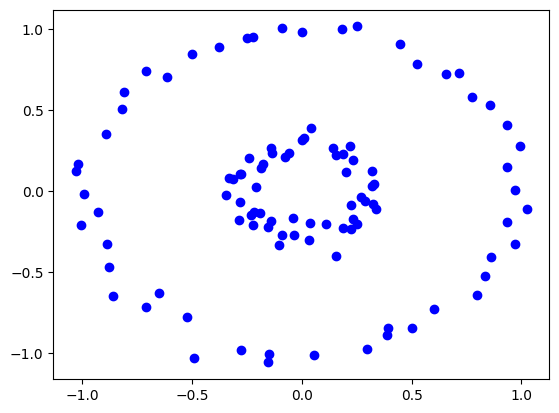

In [9]:
#Генерация данных
cs = sklearn.datasets.make_circles(n_samples=100,factor=.3, noise=0.05)[0]

bl = sklearn.datasets.make_blobs(n_samples = 200, 
                 centers = 3, 
                 n_features = 2,
                 random_state = 10,
                 cluster_std = 2) [0]


plt.plot(cs[:,0],cs[:,1], "bo")

In [11]:
#Параметры
X = bl
N = len(X)

p = 0.005
C=1/(p*N)
C

1.0

In [ ]:
L=np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        if i >= j:
          l = (norm(X[i]-X[j]))**2
          L[i,j]=l

In [ ]:
np.max(L)

4.776005709509441

In [ ]:
m=1/np.max(L)
m

0.20937998420079637

In [12]:
g = 1.0/X.shape[1]
g

0.5

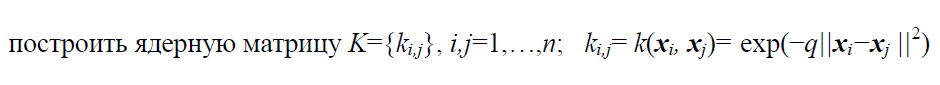

In [ ]:
#Строим ядерную матрицу 

def kernel(x_i,x_j):
    q = 5
    return 0.1*np.exp(-q*np.square(np.linalg.norm(x_i-x_j)))

K=np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        if i >= j:
            k = kernel(X[i], X[j])
            K[i,j] = k
            K[j,i] = k

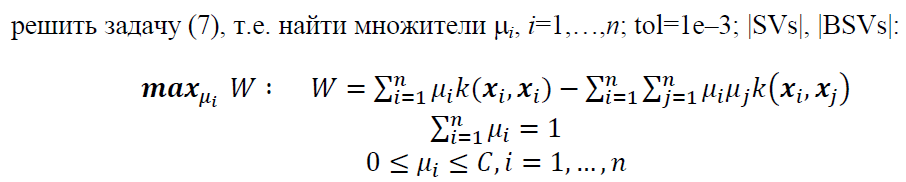

In [ ]:
#Ищем mu через pешению задачи квадpатичного пpогpаммиpования
def quadprog_solve_qp(P, q, G=None, h=None, G2=None, h2=None, A=None, b=None):
    qp_G = .5 * (P + P.T) 
    qp_a = -q
    if A is not None:
        qp_C = -np.vstack([A, G, G2]).T
        qp_b = -np.hstack([b, h, h2])
        meq = A.shape[0]
    else:
        qp_C = -np.vstack([G, G2]).T
        qp_b = -np.hstack([h, h2])
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]


Q = K + 0.00000000000001*np.identity(N)     
q = -K.diagonal()
G = -1*np.identity(N)
G2 = np.identity(N)
h = np.zeros(N)
h2 = C * np.ones(N)
b = np.zeros(N)
A = np.zeros((N,N))
A[0] = np.ones(N)

mu = quadprog_solve_qp(Q, q, G=G, G2=G2, h=h, h2=h2,A=None, b=None)
mask = (mu >0) & (mu < C)

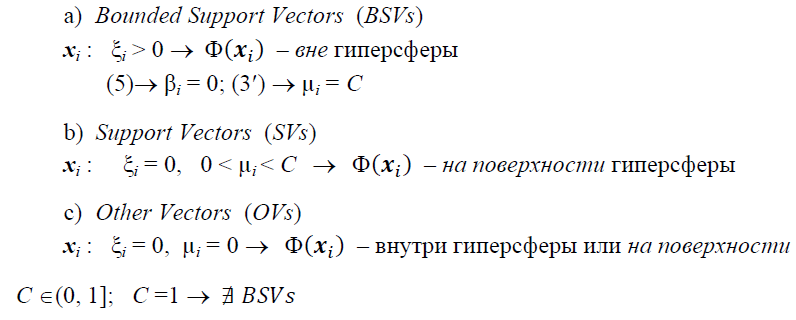

In [ ]:
#Определяем SV и BSV
svs_tmp = np.array(mu<C)*np.array(mu>0)
svs = np.where(svs_tmp==True)[0]
svs = X[svs]
bsvs_tmp = np.array(mu>=C)
bsvs = np.where(bsvs_tmp==True)[0]
bsvs=X[bsvs]

print(f'SV:{len(svs)} и BSV:{len(bsvs)}')

SV:62 и BSV:0


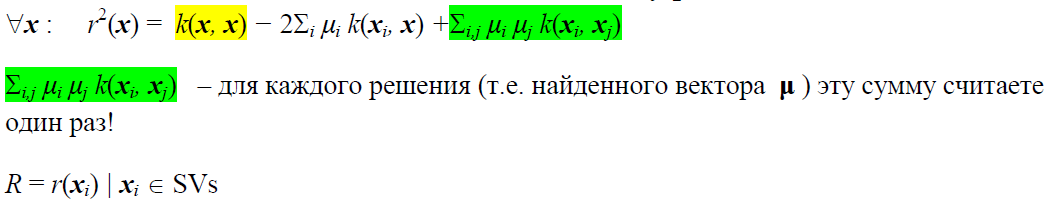

In [ ]:
points = np.zeros(N)
Kconst = 0
for t in range(0,N):
    if mask[t]:
        for s in range(0,N):
            if mask[s]:
                Kconst+=mu[t]*mu[s]*K[t,s]

def inside(x):
    x = x.reshape(-1,)
    point=kernel(x,x) + Kconst
    for j in range(0,N):
        if mask[j]:
            point-=2*mu[j]*kernel(X[j],x)
    return point

for i in range(0,N):
    points[i] = inside(X[i])
r = points[mask].max()
mask_2 = points <= r
mask_3 = mu==C
print(len(points[mask_2]))

100


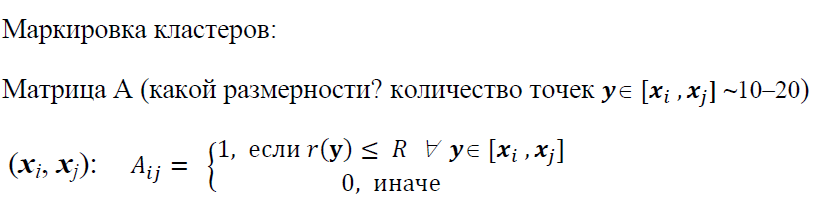

In [ ]:
#Построение матрицы смежности с 20 точками
def adjacent(x_i,x_j):
    for i in range(0,19):
        v = x_i-x_j
        inner = ((i+1)/20) * v
        if inside(inner) > r:
            return 0
    return 1

In [ ]:
inside_p = X[mask_2]
n_p=len(inside_p)
adj = np.zeros([n_p,n_p])
for i in range(0,n_p):
    #print(i)
    for j in range(0,n_p):
        if j>i:
            adj[i,j] = adjacent(inside_p[i],inside_p[j])
            adj[j,i] = adj[i,j]
        if j==i:
            adj[i,i] = 1.0
print(adj)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


In [ ]:
#Маркировка кластеров
classified = {}
class_ = {}
grey = set()
def find_cluster(i):
    if i in grey:
        return
    if i not in class_:
        class_[i] = i
        classified[i] = set([i])
    for j in range(0,n_p):
        if adj[i,j]:
            class_[j] = class_[i]
            classified[class_[i]].add(j)
    grey.add(i)
    l_classified = classified[class_[i]].copy()
    for k in l_classified:
        find_cluster(k)


for i in range(0,n_p):
    find_cluster(i)
print(classified)

{0: {0, 4, 6, 7, 8, 14, 17, 20, 21, 22, 24, 26, 28, 29, 31, 33, 34, 35, 37, 38, 39, 41, 43, 48, 49, 52, 53, 58, 59, 60, 61, 65, 67, 69, 72, 73, 78, 79, 81, 83, 84, 85, 86, 88, 90, 93, 95, 97, 98, 99}, 1: {1, 2, 3, 5, 9, 10, 11, 12, 13, 15, 16, 18, 19, 23, 25, 27, 30, 32, 36, 40, 42, 44, 45, 46, 47, 50, 51, 54, 55, 56, 57, 62, 63, 64, 66, 68, 70, 71, 74, 75, 76, 77, 80, 82, 87, 89, 91, 92, 94, 96}}


In [ ]:
clas = np.zeros(N)
c = 0
cl = 0
classes_2 = {}
print(np.sum(mask_2))
for i in range(0,N):
    if mask_2[i]:
        for k, v in classified.items():
            if c in set(v):
                if k not in classes_2:
                    cl += 1
                    classes_2[k] = cl
                clas[i] = classes_2[k]
    c+= 1
                
print(clas)

100
[1. 2. 2. 2. 1. 2. 1. 1. 1. 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 2. 1. 1. 1. 2.
 1. 2. 1. 2. 1. 1. 2. 1. 2. 1. 1. 1. 2. 1. 1. 1. 2. 1. 2. 1. 2. 2. 2. 2.
 1. 1. 2. 2. 1. 1. 2. 2. 2. 2. 1. 1. 1. 1. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2.
 1. 1. 2. 2. 2. 2. 1. 1. 2. 1. 2. 1. 1. 1. 1. 2. 1. 2. 1. 2. 2. 1. 2. 1.
 2. 1. 1. 1.]


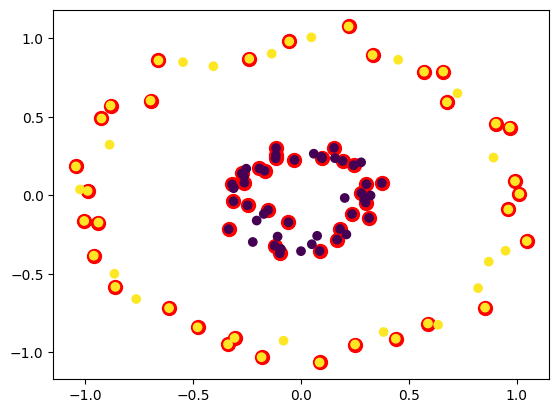

In [ ]:
labels = clas
fig, ax = plt.subplots()
ax.scatter(svs[:,0], svs[:,1], s=100, c="r")
ax.scatter(X[:,0], X[:,1],c=labels)

0 1 0


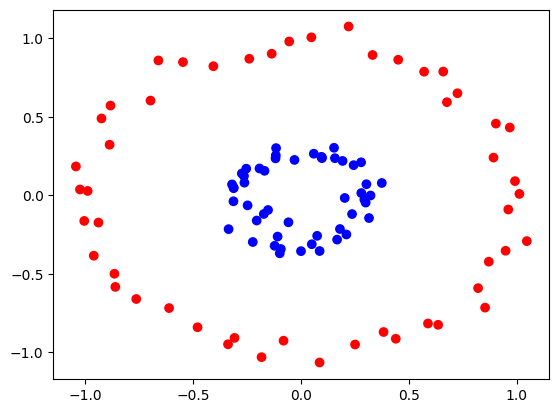

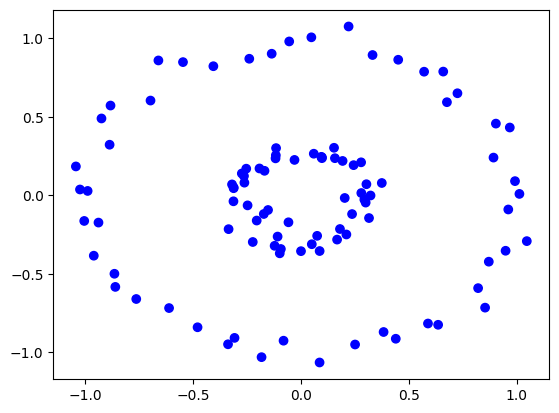

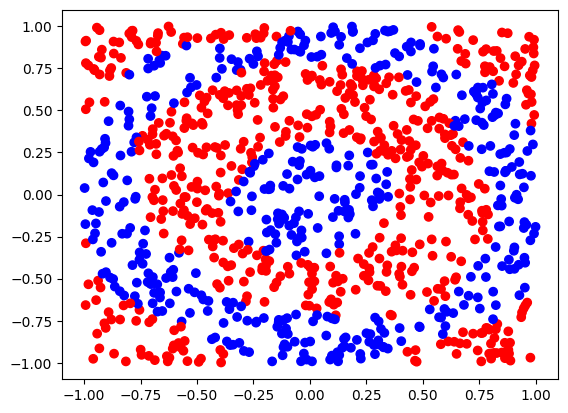

In [ ]:
x = 2*np.random.rand(2,1000)-1


def color(c):
    if c == 0:
        return 'g'
    elif c == 1:
        return 'b'
    elif c == 2:
        return 'r'
    elif c == 3:
        return 'c'
    elif c == 4:
        return 'y'
    elif c == 5:
        return 'teal'
    else:
        return 'k'
def new_color(x):
    i = inside(x)
    if i <= r:
        return 'b'
    if i > r:
        return 'r'
    return 'g'

x_1 = np.zeros((3,2))
x_1[0][0] = -1
x_1[1][0] = -0.3

print(adjacent(x_1[0],x_1[1]),adjacent(x_1[1],x_1[2]),adjacent(x_1[0],x_1[2]))

plt.scatter(X[:,0],X[:,1],c=list(map(color,clas)))
plt.show()

plt.scatter(X[:,0],X[:,1],c=list(map(new_color,X)))
plt.show()

plt.scatter(x[0],x[1],c=list(map(new_color,x.T)))
plt.show()